### Importing Libraries

In [1]:
import torch
import numpy as np
import os
import matplotlib.pyplot as plt
import PIL
from PIL import Image,ImageOps
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
import matplotlib.pyplot as plt
from torchmetrics import JaccardIndex
import datasets_segmentation as dataset


%load_ext autoreload
%autoreload 2

### Loading model and dataloaders

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

images_dir = "../../data/unet_shenken_data/"

In [3]:
#Loading Model
model = torch.hub.load('mateuszbuda/brain-segmentation-pytorch', 'unet',
                       in_channels=1, out_channels=1, init_features=32, pretrained=False)
model = model.to(device)

#Hyperparamaters
num_epochs = 100
val_check = 5
lr = 0.0002
beta1 = 0.5
optimizer = optim.Adam(model.parameters(), lr=lr, betas=(beta1, 0.999))
criterion = nn.BCELoss()
jaccard = JaccardIndex(task = 'binary', num_classes=2)

Using cache found in /home/rmpatil/.cache/torch/hub/mateuszbuda_brain-segmentation-pytorch_master


### Dice Coefficient

In [4]:
#Dice Coefficient
def dice_coeff(pred, target):
    smooth = 1.
    pred = torch.where(pred>=0.5, 1, 0)
    iflat = pred.view(-1)
    tflat = target.view(-1)
    intersection = (iflat * tflat).sum()
    
    return 1 - ((2. * intersection + smooth) /
              (iflat.sum() + tflat.sum() + smooth))

### Visualizing model outputs

In [5]:
#Function for visualization
def visualize(data,pred,label):
    batchsize = data.size()[0]
    fig, axs = plt.subplots(batchsize,3,figsize=(10,10))
    for i in range(batchsize):        
        img_plot = data[i].permute(1,2,0).detach().cpu()
        pred_plot = pred[i].permute(1,2,0).detach().cpu()
        label_plot = label[i].permute(1,2,0).detach().cpu()
        
        axs[i,0].imshow(img_plot)
        axs[i,0].set_title('Image')
        
        axs[i,1].imshow(pred_plot,cmap='gray')
        axs[i,1].set_title('Prediction')
        
        axs[i,2].imshow(label_plot,cmap='gray')
        axs[i,2].set_title('Label')
        
    plt.show()

### Validation and Test Loops

In [6]:
#Validation Loop
def validation(model,dataloader):
    losses = []
    model.eval()
    for i, (data, targets) in enumerate(dataloader, 0):
        data = data.to(device)
        targets = targets.to(device)

        pred = model(data)
        loss = criterion(pred,targets)
        losses.append(loss.item())
    return np.mean(losses)

#Test Loop
def test(model_path, dataloader):
    model = torch.hub.load('mateuszbuda/brain-segmentation-pytorch', 'unet',
                       in_channels=1, out_channels=1, init_features=32, pretrained=False)
    weights = torch.load(model_path)
    model.load_state_dict(weights)
    model = model.to(device)
    dice_scores = []
    model.eval()
    with torch.no_grad():
        for i, (data, targets) in enumerate(dataloader, 0):
            data = data.to(device)
            targets = targets.type(torch.int8).to(device)

            pred = model(data)
            dice_scores.append(jaccard(pred.cpu(), targets.cpu()))
    return np.mean(dice_scores)

### Training

In [7]:
def train(model, train_dataloader, val_dataloader, model_path):
    best_loss = np.inf

    print(f"Training for model {model_path}")
    # For each epoch
    for epoch in tqdm(range(num_epochs)):
        losses = []

        # For each batch in the dataloader
        for data, targets in train_dataloader:

            data = data.to(device)
            targets = targets.to(device).to(torch.float32)
            optimizer.zero_grad()
            pred = model(data)
            loss = criterion(pred,targets)
            loss.backward()
            optimizer.step()
            losses.append(loss.item())

        print("[TRAIN] Epoch : %d, Loss : %2.5f" % (epoch, np.mean(losses)))

        if (epoch + 1) % val_check == 0:
            visualize(data[0:3],pred[0:3],targets[0:3])

            cur_loss = validation(model, val_dataloader)
            print("[VALIDATION] Epoch : %d, Loss : %2.5f" % (epoch, cur_loss))
            if cur_loss < best_loss:
                best_loss = cur_loss
                torch.save(model.state_dict(), os.path.join("seg", model_path))  

Training for model model_basic_aug_50_train_100.pt


  0%|          | 0/100 [00:00<?, ?it/s]/opt/conda/lib/python3.9/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
  1%|          | 1/100 [00:18<30:13, 18.32s/it]

[TRAIN] Epoch : 0, Loss : 0.55390


  2%|▏         | 2/100 [00:36<29:30, 18.06s/it]

[TRAIN] Epoch : 1, Loss : 0.39521


  3%|▎         | 3/100 [00:54<29:29, 18.24s/it]

[TRAIN] Epoch : 2, Loss : 0.36808


  4%|▍         | 4/100 [01:12<28:48, 18.01s/it]

[TRAIN] Epoch : 3, Loss : 0.34225
[TRAIN] Epoch : 4, Loss : 0.33627


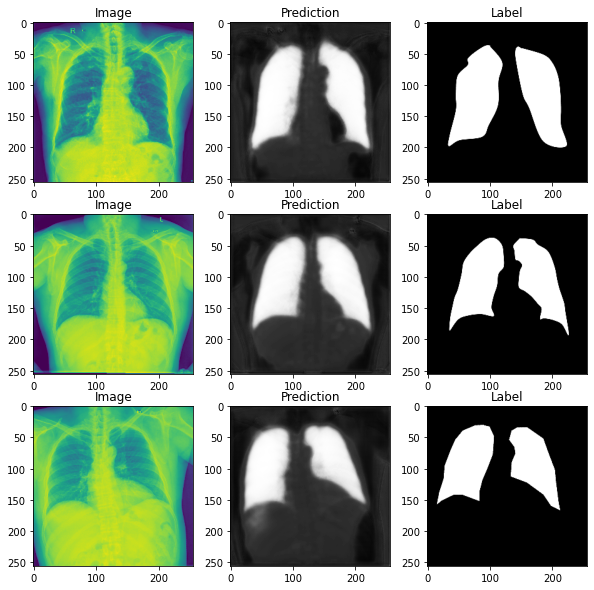

  5%|▌         | 5/100 [01:44<36:36, 23.12s/it]

[VALIDATION] Epoch : 4, Loss : 0.27373


  6%|▌         | 6/100 [02:02<33:27, 21.36s/it]

[TRAIN] Epoch : 5, Loss : 7.85130


  7%|▋         | 7/100 [02:20<31:32, 20.35s/it]

[TRAIN] Epoch : 6, Loss : 0.40983


  8%|▊         | 8/100 [02:38<30:00, 19.57s/it]

[TRAIN] Epoch : 7, Loss : 0.35713


  9%|▉         | 9/100 [02:56<28:47, 18.98s/it]

[TRAIN] Epoch : 8, Loss : 0.31967
[TRAIN] Epoch : 9, Loss : 0.26821


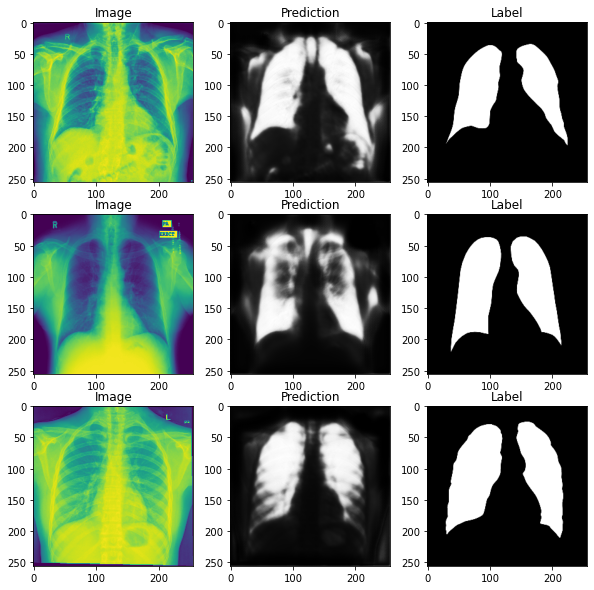

 10%|█         | 10/100 [03:27<34:10, 22.78s/it]

[VALIDATION] Epoch : 9, Loss : 0.16092


 11%|█         | 11/100 [03:45<31:27, 21.20s/it]

[TRAIN] Epoch : 10, Loss : 0.27948


 12%|█▏        | 12/100 [04:03<29:47, 20.32s/it]

[TRAIN] Epoch : 11, Loss : 0.24816


 13%|█▎        | 13/100 [04:20<28:10, 19.44s/it]

[TRAIN] Epoch : 12, Loss : 0.20978


 14%|█▍        | 14/100 [04:38<27:08, 18.94s/it]

[TRAIN] Epoch : 13, Loss : 0.21661
[TRAIN] Epoch : 14, Loss : 0.21002


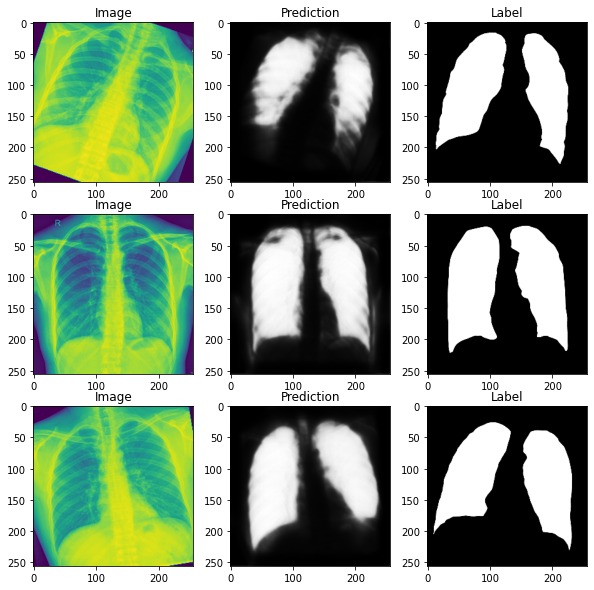

 15%|█▌        | 15/100 [05:10<32:19, 22.81s/it]

[VALIDATION] Epoch : 14, Loss : 0.11402


 16%|█▌        | 16/100 [05:28<29:49, 21.31s/it]

[TRAIN] Epoch : 15, Loss : 0.20493


 17%|█▋        | 17/100 [05:46<28:19, 20.48s/it]

[TRAIN] Epoch : 16, Loss : 0.20473


 18%|█▊        | 18/100 [06:04<26:54, 19.69s/it]

[TRAIN] Epoch : 17, Loss : 0.19578


 19%|█▉        | 19/100 [06:23<26:01, 19.27s/it]

[TRAIN] Epoch : 18, Loss : 0.18813
[TRAIN] Epoch : 19, Loss : 0.19158


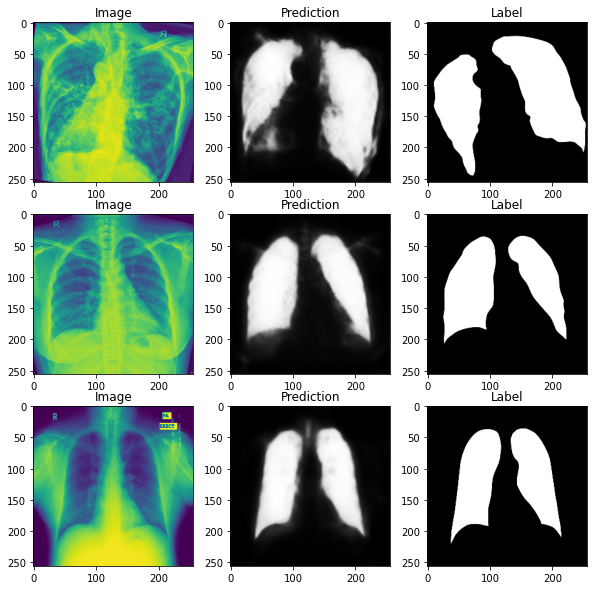

[VALIDATION] Epoch : 19, Loss : 0.09107


 21%|██        | 21/100 [07:13<28:23, 21.56s/it]

[TRAIN] Epoch : 20, Loss : 0.20372


 22%|██▏       | 22/100 [07:32<27:06, 20.85s/it]

[TRAIN] Epoch : 21, Loss : 0.18038


 23%|██▎       | 23/100 [07:51<26:14, 20.44s/it]

[TRAIN] Epoch : 22, Loss : 0.17727


 24%|██▍       | 24/100 [08:09<24:48, 19.59s/it]

[TRAIN] Epoch : 23, Loss : 0.17072
[TRAIN] Epoch : 24, Loss : 0.17785


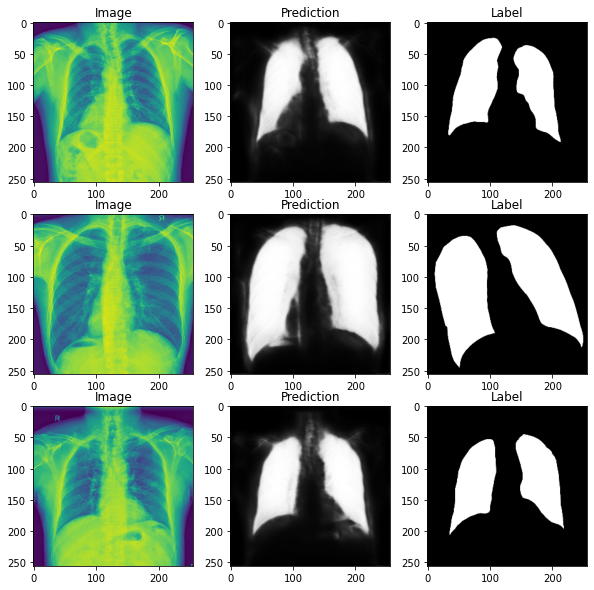

 25%|██▌       | 25/100 [08:41<29:05, 23.28s/it]

[VALIDATION] Epoch : 24, Loss : 0.08946


 26%|██▌       | 26/100 [08:58<26:35, 21.57s/it]

[TRAIN] Epoch : 25, Loss : 0.15622


 27%|██▋       | 27/100 [09:16<24:52, 20.45s/it]

[TRAIN] Epoch : 26, Loss : 0.17721


 28%|██▊       | 28/100 [09:34<23:37, 19.68s/it]

[TRAIN] Epoch : 27, Loss : 0.18776


 29%|██▉       | 29/100 [09:52<22:41, 19.18s/it]

[TRAIN] Epoch : 28, Loss : 0.17846
[TRAIN] Epoch : 29, Loss : 0.18009


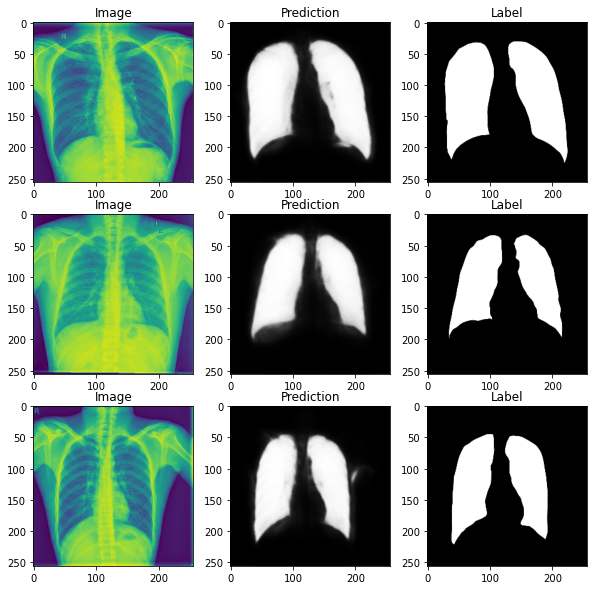

 30%|███       | 30/100 [10:25<27:12, 23.32s/it]

[VALIDATION] Epoch : 29, Loss : 0.08250


 31%|███       | 31/100 [10:43<25:01, 21.76s/it]

[TRAIN] Epoch : 30, Loss : 0.15925


 32%|███▏      | 32/100 [11:01<23:21, 20.61s/it]

[TRAIN] Epoch : 31, Loss : 0.17524


 33%|███▎      | 33/100 [11:20<22:20, 20.00s/it]

[TRAIN] Epoch : 32, Loss : 0.17291


 34%|███▍      | 34/100 [11:38<21:18, 19.37s/it]

[TRAIN] Epoch : 33, Loss : 0.15716
[TRAIN] Epoch : 34, Loss : 0.17154


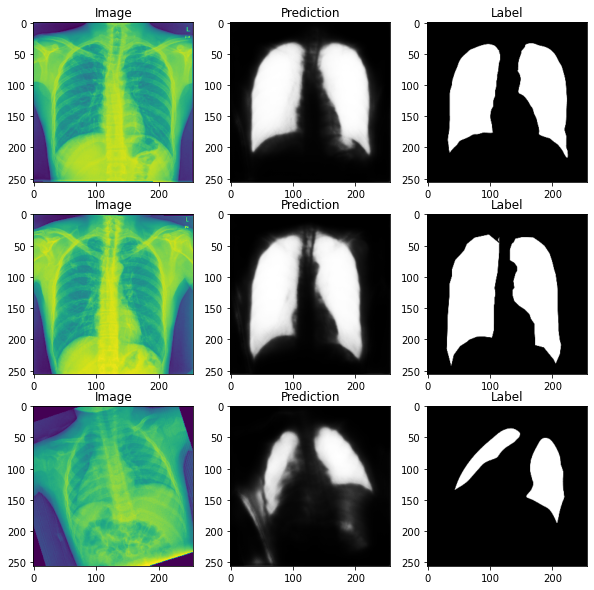

 35%|███▌      | 35/100 [12:10<25:06, 23.17s/it]

[VALIDATION] Epoch : 34, Loss : 0.08870


 36%|███▌      | 36/100 [12:27<22:55, 21.49s/it]

[TRAIN] Epoch : 35, Loss : 0.16498


 37%|███▋      | 37/100 [12:46<21:31, 20.50s/it]

[TRAIN] Epoch : 36, Loss : 0.17015


 38%|███▊      | 38/100 [13:04<20:30, 19.84s/it]

[TRAIN] Epoch : 37, Loss : 0.15556


 39%|███▉      | 39/100 [13:22<19:42, 19.38s/it]

[TRAIN] Epoch : 38, Loss : 0.16427
[TRAIN] Epoch : 39, Loss : 0.16358


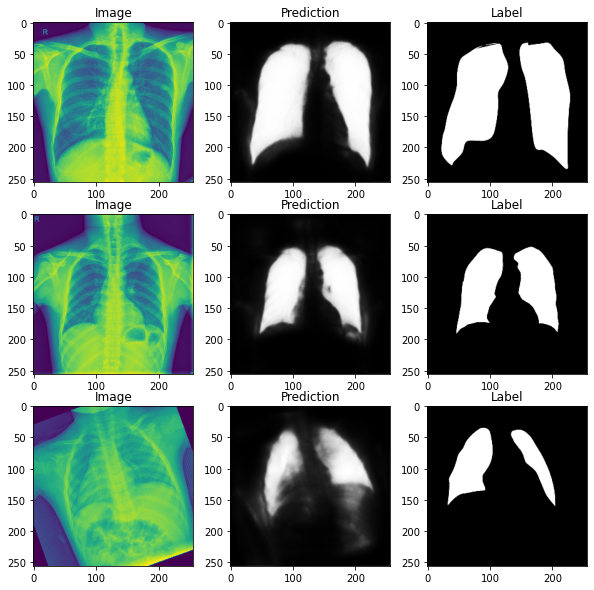

 40%|████      | 40/100 [13:54<23:05, 23.09s/it]

[VALIDATION] Epoch : 39, Loss : 0.09119


 41%|████      | 41/100 [14:11<21:05, 21.45s/it]

[TRAIN] Epoch : 40, Loss : 0.15655


 42%|████▏     | 42/100 [14:30<19:47, 20.48s/it]

[TRAIN] Epoch : 41, Loss : 0.15371


 43%|████▎     | 43/100 [14:47<18:41, 19.67s/it]

[TRAIN] Epoch : 42, Loss : 0.15235


 44%|████▍     | 44/100 [15:05<17:47, 19.06s/it]

[TRAIN] Epoch : 43, Loss : 0.15862
[TRAIN] Epoch : 44, Loss : 0.14995


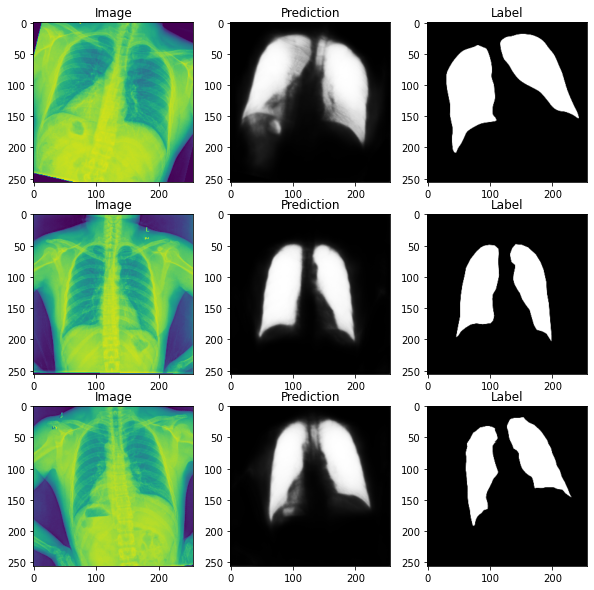

 45%|████▌     | 45/100 [15:37<21:07, 23.05s/it]

[VALIDATION] Epoch : 44, Loss : 0.07879


 46%|████▌     | 46/100 [15:55<19:22, 21.54s/it]

[TRAIN] Epoch : 45, Loss : 0.16877


 47%|████▋     | 47/100 [16:14<18:14, 20.66s/it]

[TRAIN] Epoch : 46, Loss : 0.15533


 48%|████▊     | 48/100 [16:32<17:11, 19.84s/it]

[TRAIN] Epoch : 47, Loss : 0.15713


 49%|████▉     | 49/100 [16:50<16:28, 19.39s/it]

[TRAIN] Epoch : 48, Loss : 0.15919
[TRAIN] Epoch : 49, Loss : 0.14608


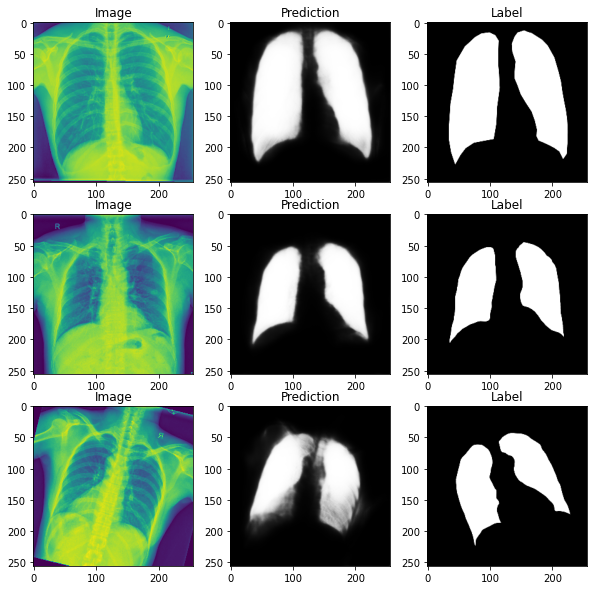

[VALIDATION] Epoch : 49, Loss : 0.06665


 51%|█████     | 51/100 [17:40<17:39, 21.62s/it]

[TRAIN] Epoch : 50, Loss : 0.16282


 52%|█████▏    | 52/100 [17:58<16:22, 20.46s/it]

[TRAIN] Epoch : 51, Loss : 0.16324


 53%|█████▎    | 53/100 [18:16<15:23, 19.65s/it]

[TRAIN] Epoch : 52, Loss : 0.15994


 54%|█████▍    | 54/100 [18:33<14:31, 18.95s/it]

[TRAIN] Epoch : 53, Loss : 0.16525
[TRAIN] Epoch : 54, Loss : 0.15436


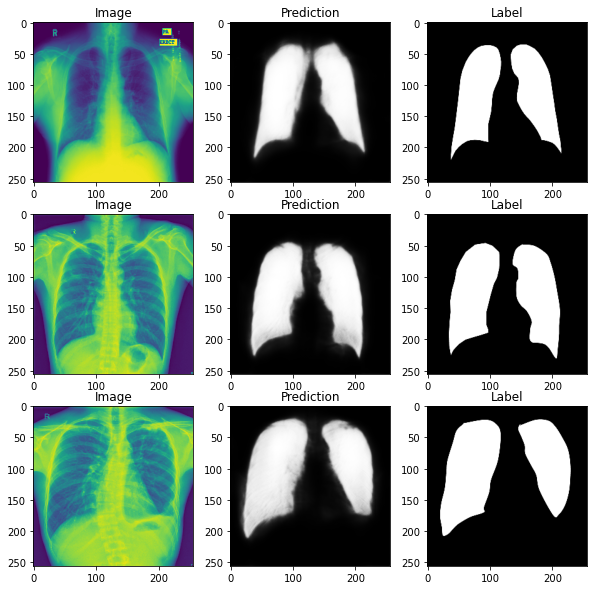

 55%|█████▌    | 55/100 [19:05<17:10, 22.91s/it]

[VALIDATION] Epoch : 54, Loss : 0.07068


 56%|█████▌    | 56/100 [19:24<15:47, 21.52s/it]

[TRAIN] Epoch : 55, Loss : 0.15948


 57%|█████▋    | 57/100 [19:42<14:43, 20.54s/it]

[TRAIN] Epoch : 56, Loss : 0.14826


 58%|█████▊    | 58/100 [20:00<13:54, 19.86s/it]

[TRAIN] Epoch : 57, Loss : 0.15556


 59%|█████▉    | 59/100 [20:19<13:15, 19.40s/it]

[TRAIN] Epoch : 58, Loss : 0.15206
[TRAIN] Epoch : 59, Loss : 0.14343


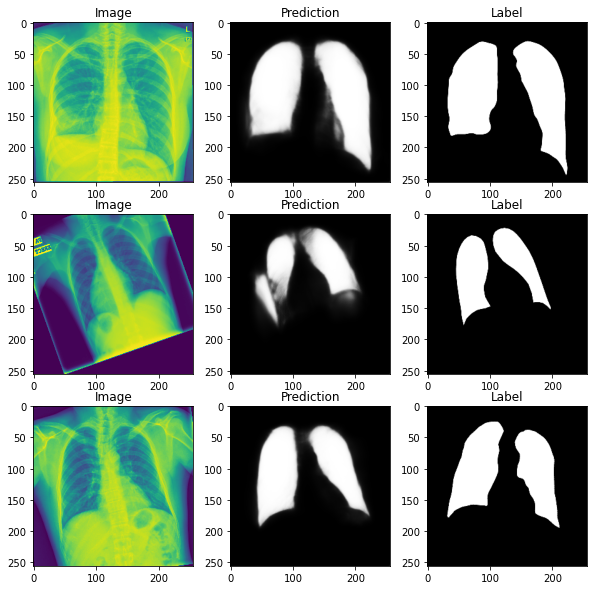

 60%|██████    | 60/100 [20:51<15:30, 23.27s/it]

[VALIDATION] Epoch : 59, Loss : 0.06334


 61%|██████    | 61/100 [21:09<14:02, 21.60s/it]

[TRAIN] Epoch : 60, Loss : 0.15015


 62%|██████▏   | 62/100 [21:26<12:57, 20.46s/it]

[TRAIN] Epoch : 61, Loss : 0.15848


 63%|██████▎   | 63/100 [21:44<12:09, 19.72s/it]

[TRAIN] Epoch : 62, Loss : 0.14854


 64%|██████▍   | 64/100 [22:02<11:33, 19.26s/it]

[TRAIN] Epoch : 63, Loss : 0.15049
[TRAIN] Epoch : 64, Loss : 0.14272


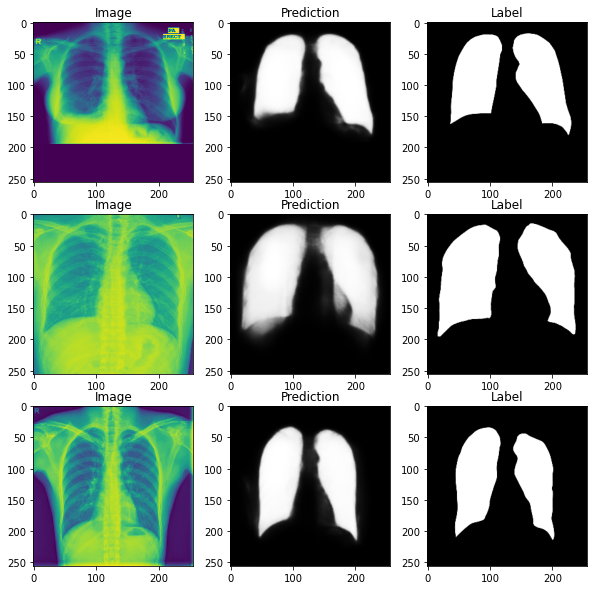

 65%|██████▌   | 65/100 [22:34<13:22, 22.93s/it]

[VALIDATION] Epoch : 64, Loss : 0.06869


 66%|██████▌   | 66/100 [22:52<12:13, 21.58s/it]

[TRAIN] Epoch : 65, Loss : 0.13619


 67%|██████▋   | 67/100 [23:11<11:17, 20.53s/it]

[TRAIN] Epoch : 66, Loss : 0.14587


 68%|██████▊   | 68/100 [23:29<10:38, 19.96s/it]

[TRAIN] Epoch : 67, Loss : 0.14397


 69%|██████▉   | 69/100 [23:47<09:58, 19.32s/it]

[TRAIN] Epoch : 68, Loss : 0.14681
[TRAIN] Epoch : 69, Loss : 0.13852


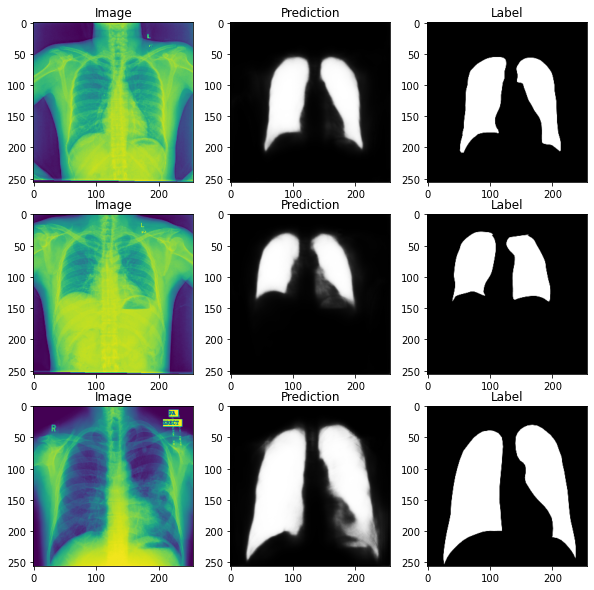

 70%|███████   | 70/100 [24:18<11:27, 22.92s/it]

[VALIDATION] Epoch : 69, Loss : 0.07715


 71%|███████   | 71/100 [24:37<10:26, 21.60s/it]

[TRAIN] Epoch : 70, Loss : 0.12915


 72%|███████▏  | 72/100 [24:54<09:29, 20.33s/it]

[TRAIN] Epoch : 71, Loss : 0.14070


 73%|███████▎  | 73/100 [25:13<08:54, 19.79s/it]

[TRAIN] Epoch : 72, Loss : 0.15223


 74%|███████▍  | 74/100 [25:31<08:24, 19.41s/it]

[TRAIN] Epoch : 73, Loss : 0.14424
[TRAIN] Epoch : 74, Loss : 0.13375


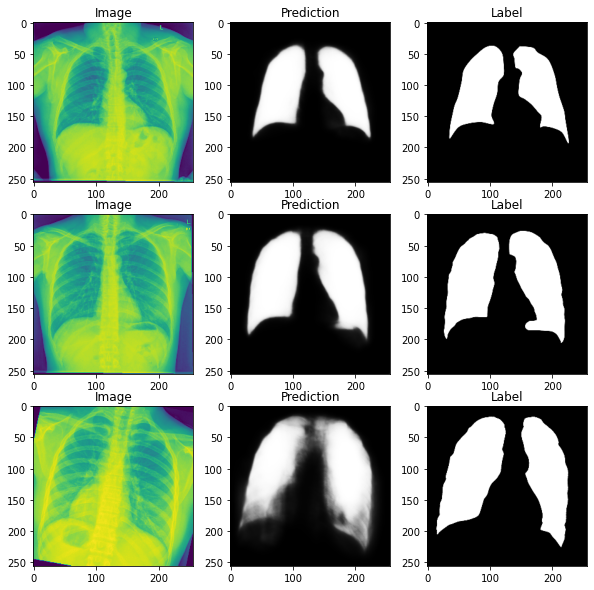

 75%|███████▌  | 75/100 [26:04<09:45, 23.42s/it]

[VALIDATION] Epoch : 74, Loss : 0.06244


 76%|███████▌  | 76/100 [26:22<08:41, 21.71s/it]

[TRAIN] Epoch : 75, Loss : 0.13874


 77%|███████▋  | 77/100 [26:40<07:53, 20.59s/it]

[TRAIN] Epoch : 76, Loss : 0.14102


 78%|███████▊  | 78/100 [26:58<07:16, 19.84s/it]

[TRAIN] Epoch : 77, Loss : 0.13655


 79%|███████▉  | 79/100 [27:16<06:44, 19.26s/it]

[TRAIN] Epoch : 78, Loss : 0.13287
[TRAIN] Epoch : 79, Loss : 0.13309


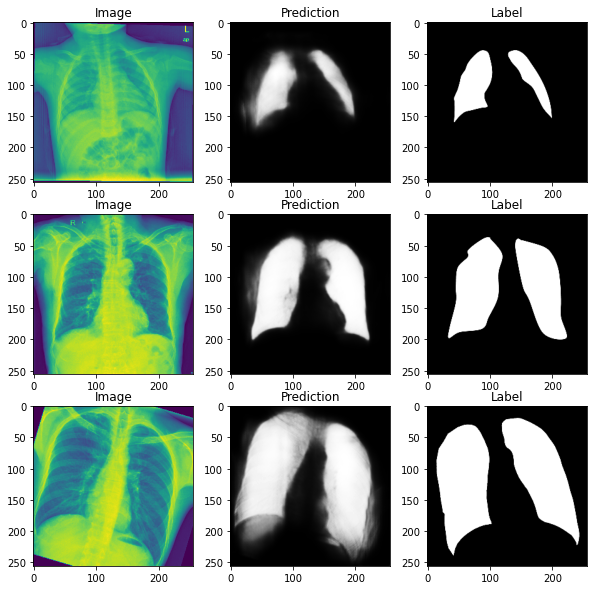

 80%|████████  | 80/100 [27:48<07:40, 23.05s/it]

[VALIDATION] Epoch : 79, Loss : 0.07839


 81%|████████  | 81/100 [28:06<06:51, 21.64s/it]

[TRAIN] Epoch : 80, Loss : 0.14048


 82%|████████▏ | 82/100 [28:24<06:10, 20.60s/it]

[TRAIN] Epoch : 81, Loss : 0.13001


 83%|████████▎ | 83/100 [28:42<05:35, 19.73s/it]

[TRAIN] Epoch : 82, Loss : 0.15495


 84%|████████▍ | 84/100 [29:00<05:07, 19.21s/it]

[TRAIN] Epoch : 83, Loss : 0.13547
[TRAIN] Epoch : 84, Loss : 0.13099


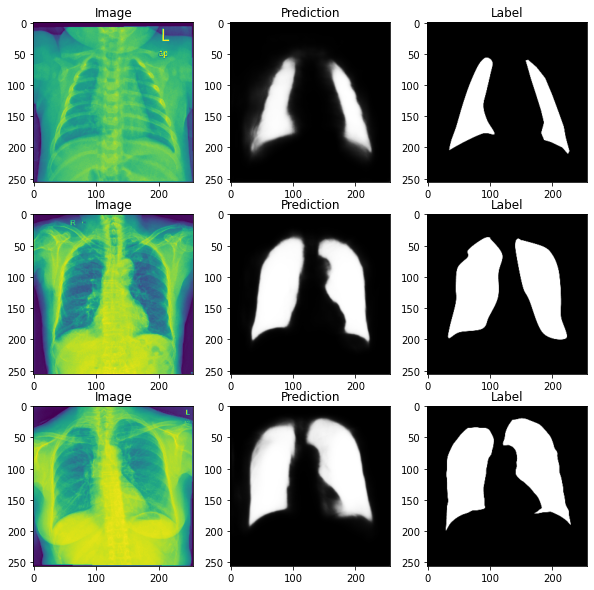

 85%|████████▌ | 85/100 [29:35<06:02, 24.15s/it]

[VALIDATION] Epoch : 84, Loss : 0.07434


 86%|████████▌ | 86/100 [29:56<05:22, 23.03s/it]

[TRAIN] Epoch : 85, Loss : 0.13424


 87%|████████▋ | 87/100 [30:17<04:50, 22.33s/it]

[TRAIN] Epoch : 86, Loss : 0.14039


 88%|████████▊ | 88/100 [30:37<04:20, 21.72s/it]

[TRAIN] Epoch : 87, Loss : 0.14198


 89%|████████▉ | 89/100 [30:57<03:54, 21.34s/it]

[TRAIN] Epoch : 88, Loss : 0.14383
[TRAIN] Epoch : 89, Loss : 0.14982


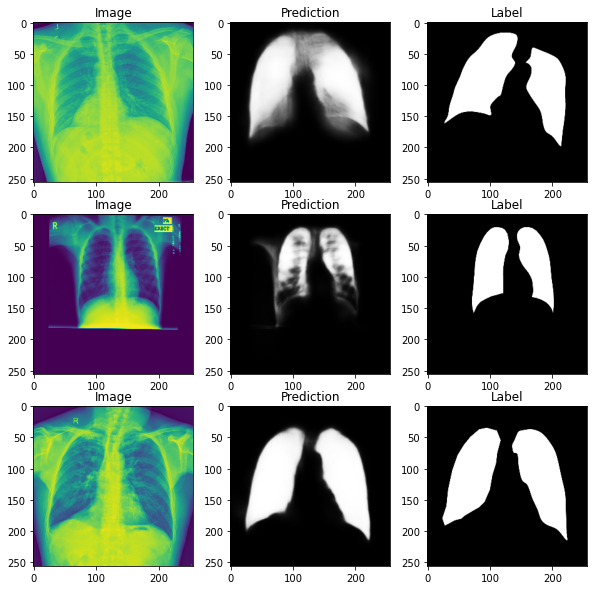

 90%|█████████ | 90/100 [31:33<04:17, 25.77s/it]

[VALIDATION] Epoch : 89, Loss : 0.07159


 91%|█████████ | 91/100 [31:53<03:35, 23.96s/it]

[TRAIN] Epoch : 90, Loss : 0.14244


 92%|█████████▏| 92/100 [32:11<02:57, 22.20s/it]

[TRAIN] Epoch : 91, Loss : 0.13434


 93%|█████████▎| 93/100 [32:29<02:26, 20.96s/it]

[TRAIN] Epoch : 92, Loss : 0.13592


 94%|█████████▍| 94/100 [32:47<02:00, 20.02s/it]

[TRAIN] Epoch : 93, Loss : 0.13783
[TRAIN] Epoch : 94, Loss : 0.13340


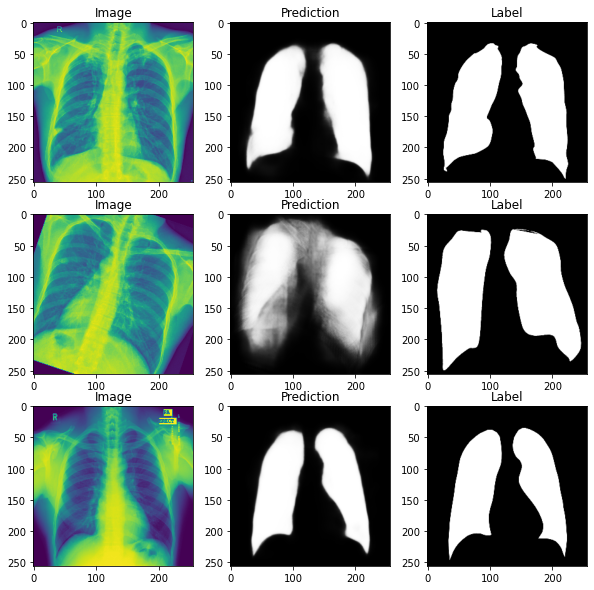

 95%|█████████▌| 95/100 [33:20<01:59, 23.83s/it]

[VALIDATION] Epoch : 94, Loss : 0.07502


 96%|█████████▌| 96/100 [33:38<01:28, 22.07s/it]

[TRAIN] Epoch : 95, Loss : 0.13147


 97%|█████████▋| 97/100 [33:56<01:02, 20.76s/it]

[TRAIN] Epoch : 96, Loss : 0.12333


 98%|█████████▊| 98/100 [34:14<00:39, 19.97s/it]

[TRAIN] Epoch : 97, Loss : 0.13025


 99%|█████████▉| 99/100 [34:32<00:19, 19.41s/it]

[TRAIN] Epoch : 98, Loss : 0.13530
[TRAIN] Epoch : 99, Loss : 0.12543


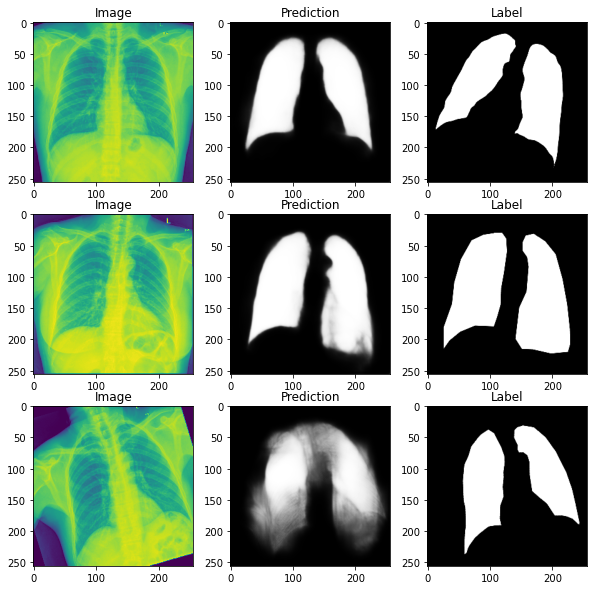

100%|██████████| 100/100 [35:04<00:00, 21.04s/it]

[VALIDATION] Epoch : 99, Loss : 0.06386


In [8]:
train_size = 100
use_augmentation = True
augmentation_type = "basic"
augmentation_size = 50
augmentation_dir = ""
model_path = f"model_{augmentation_type}_aug_{augmentation_size}_train_{train_size}.pt"

# get datasets
train_set = dataset.get_train_data(images_dir,
                                   train_size = train_size,
                                   use_augmentation = use_augmentation,
                                   augmentation_type = augmentation_type,
                                   augmentation_size = augmentation_size,
                                   augmentation_dir = augmentation_dir)
val_set = dataset.get_val_data(images_dir)
test_set = dataset.get_test_data(images_dir)

# setup dataloaders
batch_size = 8
train_dataloader = DataLoader(train_set, batch_size = batch_size, shuffle = True)
val_dataloader = DataLoader(val_set, batch_size = batch_size, shuffle = True)
test_dataloader = DataLoader(test_set, batch_size = 1, shuffle = True)

train(model, train_dataloader, val_dataloader, model_path)

### Test accuracy of all the models

In [ ]:
model_names = sorted([i for i in os.listdir('seg') if i.endswith('.pt')])
for model in model_names:
    test_accuracy = test(os.path.join('seg/', model), test_dataloader)
    print(model, test_accuracy)

### Results - Dice Scores



|Train Size| Without Augmentation | Baseline Augmentation| With Augmentation |
| :-: | :-: |:-: | :-: |
| 0   | -       | 0.794 | 0.826 |
| 20  | 0.863  | 0.907 | 0.922  |
| 50  | 0.904  | 0.938 | 0.931 |
| 100 | 0.935 | 0.940 | 0.948 |
| 200 | 0.946 | 0.948 | 0.950 |